# Fashion-MNIST Custom Neural Network Training
University of Ljubljana, Faculty of Computer and Information Science
Course: Machine Learning, 2024-2025

Teodora Taleska

## Environment Setup

In [2]:
import torch
import gzip
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

## Load the Data

Load the Fashion-MNIST dataset from the official Fashion-MNIST GitHub repository using the `utils.mnist_reader` module. The dataset consists of 60,000 training samples, each belonging to one of 10 fashion-related classes. Then, normalize the training sample values to the range [0, 1] and visualize one random member from each of the 10 classes.


In [3]:
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)
    return data

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

train_images = load_mnist_images('../data/fashion/train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('../data/fashion/train-labels-idx1-ubyte.gz')
test_images = load_mnist_images('../data/fashion/t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('../data/fashion/t10k-labels-idx1-ubyte.gz')

print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")

print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


### Normalize the Data

After loading the data, normalize the pixel values of the training samples to the range [0, 1]. This step ensures that all features are on a consistent scale, making them suitable for use in neural network model. The normalization is performed by dividing each pixel value by 255, which is the maximum possible intensity in the dataset.

In [6]:
# split the training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Reshape images to [N, 1, 28, 28] and convert to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32).unsqueeze(1) / 255.0
val_images = torch.tensor(val_images, dtype=torch.float32).unsqueeze(1) / 255.0
test_images = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1) / 255.0

# Ensure labels are integer class indices before one-hot encoding
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

# Convert labels to one-hot encoding
train_labels = F.one_hot(train_labels, num_classes=10).float()
val_labels = F.one_hot(val_labels, num_classes=10).float()
test_labels = F.one_hot(test_labels, num_classes=10).float()

print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")

Train images shape: torch.Size([30720, 1, 28, 28]), Train labels shape: torch.Size([30720, 10])
Validation images shape: torch.Size([7680, 1, 28, 28]), Validation labels shape: torch.Size([7680, 10])
Test images shape: torch.Size([10000, 1, 28, 28]), Test labels shape: torch.Size([10000, 10])


## Implementing the Dataset Class
In this section, I define a custom `Dataset` class to handle batched and shuffled data for training and validation. The class supports the following functionalities:
- Initialization of the dataset with samples, labels, and batch size.
- Batch-wise access to data using the `__getitem__` method.
- Determining the number of batches using the `__len__` method.
- Shuffling the dataset samples and labels using the `shuffle` method.


In [7]:
class Dataset:
    def __init__(self, samples, labels, batch_size):
        """
        Initialize the dataset with samples, labels, and batch size.
        
        Args:
            samples (torch.Tensor): The dataset samples of shape [N, 1, 28, 28].
            labels (torch.Tensor): The dataset labels of shape [N, num_classes].
            batch_size (int): The number of samples per batch.
        """
        self.samples = samples
        self.labels = labels
        self.batch_size = batch_size
        self.indices = torch.arange(len(samples))  # Initialize indices for deterministic access
    
    def __getitem__(self, index):
        """
        Return the batch of samples and labels corresponding to the given index.
        
        Args:
            index (int): The batch index.
            
        Returns:
            batch_samples (torch.Tensor): The batch samples of shape [batch_size, 1, 28, 28].
            batch_labels (torch.Tensor): The batch labels of shape [batch_size, num_classes].
        """
        start_idx = index * self.batch_size
        end_idx = min(start_idx + self.batch_size, len(self.samples))  # Handle last batch
        batch_indices = self.indices[start_idx:end_idx]
        return self.samples[batch_indices], self.labels[batch_indices]
    
    def __len__(self):
        """
        Return the number of batches in the dataset.
        
        Returns:
            int: The number of batches.
        """
        return (len(self.samples) + self.batch_size - 1) // self.batch_size  # Ceiling division
    
    def shuffle(self):
        """
        Shuffle the dataset samples and labels by permuting the indices.
        """
        self.indices = torch.randperm(len(self.samples))

train_dataset = Dataset(train_images, train_labels, batch_size=64)
val_dataset = Dataset(val_images, val_labels, batch_size=64)

In [11]:
batch1_a, labels1_a = train_dataset[1]
batch1_b, labels1_b = train_dataset[1]
assert torch.equal(batch1_a, batch1_b) and torch.equal(labels1_a, labels1_b), "Batches are not deterministic!"
print("Determinism confirmed!")

Determinism confirmed!


### Visualize the data
Visualization of 16 samples from a batch belonging to the training dataset and their corresponding class labels.

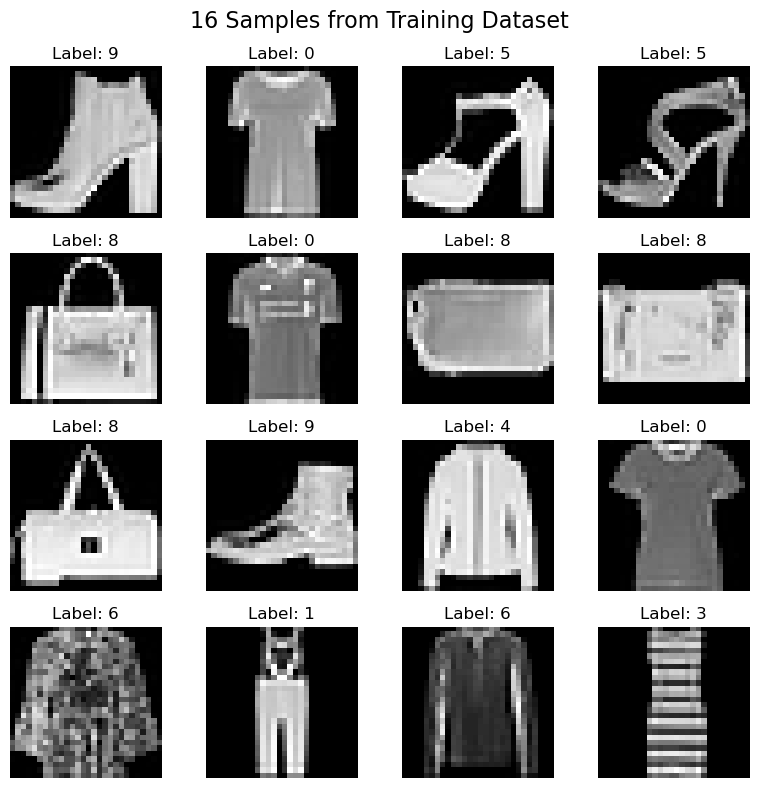

In [8]:
# Get the first batch from the training dataset
batch_samples, batch_labels = train_dataset[0]

# Select the first 16 samples and labels
images = batch_samples[:16].squeeze(1).numpy()
labels = torch.argmax(batch_labels[:16], dim=1).numpy()

# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle("16 Samples from Training Dataset", fontsize=16)

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i], cmap="gray")
    ax.set_title(f"Label: {labels[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()
